In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [81]:
from importlib import reload
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl


import deep_morpho.models.pconv as pconv
import deep_morpho.models.lightning_pconv as lpconv
import deep_morpho.models.dilation_layer as dill
import deep_morpho.models.lightning_dilation_layer as ldill
import deep_morpho.datasets.generate_forms as gfo

def reload_modules():
    for modl in [pconv, lpconv, dill, ldill, gfo]:
        reload(modl)
        
reload_modules()

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

cuda


In [47]:
x = torch.zeros((1, 50, 50))
x[0, -25:35, -25:35] = 1

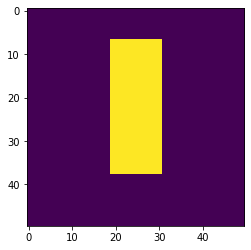

In [101]:
reload_modules()
x = gfo.random_rectangle((50, 50))
plt.imshow(x)

In [72]:
reload_modules()
mpc = dill.DilationLayer(in_channels=1, out_channels=1, kernel_size=(5, 5))


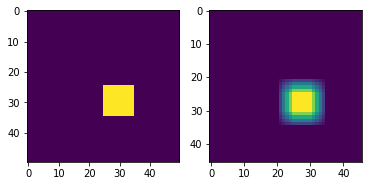

In [76]:
fig = plt.figure()

ax = fig.add_subplot(121)
ax.imshow(x[0])

ax = fig.add_subplot(122)
ax.imshow(mpc(x.unsqueeze(0)).detach()[0, 0])

In [78]:
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

model = ldill.LightningDilationLayer(
    model_args={
        "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5)
    },
    learning_rate=1e-4,
    loss=loss,
    optimizer=optimizer,
    output_dir="deep_morpho/results"
)

In [66]:
super(dill.DilationLayer).forward(x.unsqueeze(0))

AttributeError: 'super' object has no attribute 'forward'

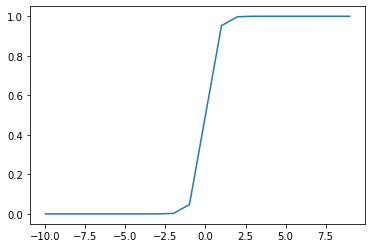

In [41]:
x = torch.arange(-10, 10)
plt.plot(x, torch.sigmoid(3*x))